In [1]:
from cmb.configs.utils import Configs
from cmb.datasets.jetclass import JetsClassData

config = Configs('epic.yaml') 
jets = JetsClassData(config.data, task='train')

INFO: created experiment instance gauss_to_tbqq_FlowMatching_EPiC_2024.10.08_01h20_5294
INFO: Loading train datasets.


TypeError: argument of type 'NoneType' is not iterable

In [3]:
import torch 

dat = torch.cat([jets.target.continuous, jets.target.mask], dim=-1)

NameError: name 'jets' is not defined

In [9]:
rrr = 'lskgl'

if rrr is None :
    print('yes')
elif 'onehot' in rrr:
    print('no')

## JetClass data visualization

In [2]:
(jets.target.continuous.shape, 
jets.source.continuous.shape, 
# jets.target.discrete.shape,
# jets.source.discrete.shape,
jets.target.mask.shape,
jets.source.mask.shape)

(torch.Size([100000, 128, 11]),
 torch.Size([100000, 128, 11]),
 torch.Size([100000, 128, 1]),
 torch.Size([100000, 128, 1]))

In [11]:
jets.target.continuous[0][-20:]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.,

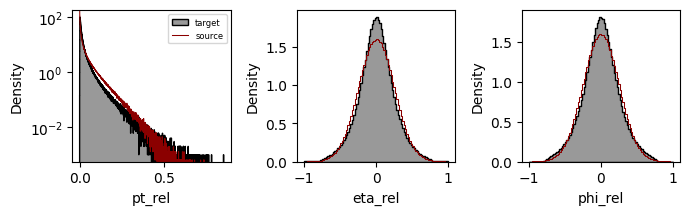

In [5]:
mask_target = (jets.target.mask > 0).squeeze() 
mask_source = (jets.source.mask > 0).squeeze() 

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(7,2.25))
jets.target.histplot('pt_rel', mask=mask_target, ax=ax[0], stat='density', log_scale=(False,True), color='k', alpha=0.4, label='target')
jets.source.histplot('pt_rel', mask=mask_source, ax=ax[0], stat='density',  log_scale=(False,True), color='darkred', fill=False, lw=0.75, label='source')
jets.target.histplot('eta_rel', mask=mask_target, binrange=(-1,1), binwidth=0.02,ax=ax[1], stat='density',  color='k', alpha=0.4, label='target')
jets.source.histplot('eta_rel', mask=mask_source, binrange=(-1,1), binwidth=0.02, ax=ax[1], stat='density',  color='darkred', fill=False, lw=0.75, label='source')
jets.target.histplot('phi_rel', mask=mask_target, binrange=(-1,1), binwidth=0.02, ax=ax[2], stat='density', color='k', alpha=0.4, label='target')
jets.source.histplot('phi_rel', mask=mask_source, binrange=(-1,1), binwidth=0.02,ax=ax[2], stat='density',  color='darkred', fill=False, lw=0.75, label='source')
ax[0].legend(fontsize=6)
plt.tight_layout()
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

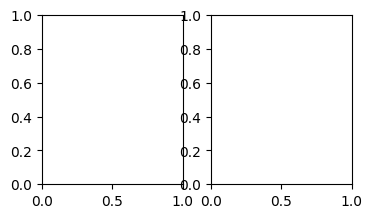

In [2]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1,2, figsize=(4, 2.2))
jets.source.display_cloud(idx=10,  scale_marker=100.0, ax=ax[0])
jets.target.display_cloud(idx=10,  scale_marker=100.0, ax=ax[1])
ax[0].set_title('beta-gauss source', fontsize=6)
ax[1].set_title('top-jet target', fontsize=6)
plt.tight_layout()
plt.show()

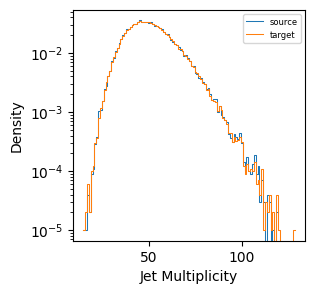

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.histplot(jets.source.multiplicity, element="step", fill=False, discrete=True, lw=0.75, stat='density', log_scale=(False, True),  ax=ax, label='source')
sns.histplot(jets.target.multiplicity, element="step", fill=False, discrete=True, lw=0.75, stat='density', log_scale=(False, True),  ax=ax, label='target')
ax.legend(fontsize=6)
ax.set_xlabel('Jet Multiplicity')
plt.show()

## Train CFM

2024-10-07 19:49:55.868964: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 19:49:55.906326: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 19:49:55.906820: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-07 19:49:56.679662: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO: Conditional Markov Bridge initialized...
      - continuous process:  FlowMatching
      - discrete process:  None
      - solver method:  EulerSolver
INFO: Standardizing source data...
INFO: Standardizing target data.


INFO: number of training parameters: 801586
INFO: start training...


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.8/0.2/0.0
INFO: train size: 80000, validation size: 20000, testing sizes: 0


epochs:   0%|          | 0/100 [00:00<?, ?it/s]

/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


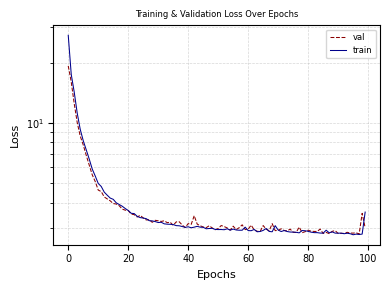

In [12]:
from cmb.models.trainers import GenerativeDynamicsModule
epic_cfm = GenerativeDynamicsModule(config, jets)
epic_cfm.train()


# Inference

### load trained model

In [1]:
from cmb.models.trainers import GenerativeDynamicsModule

path='/home/df630/CMB/results/JetClass/gauss_to_tbqq_FlowMatching_EPiC_2024.10.07_19h46_2189/config.yaml'
epic_cfm = GenerativeDynamicsModule(config=path, device='cuda:2')
epic_cfm.load(checkpoint='best')


2024-10-07 20:51:55.489490: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 20:51:55.534947: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 20:51:55.536011: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-07 20:51:56.270250: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO: Conditional Markov Bridge initialized...
      - continuous process:  FlowMatching
      - discrete process:  None
      - solver method:  EulerSolver
INFO: loading `best` epoch checkpoint on cuda:2 from:
  - /home/df630/CMB/results/JetClass/gauss_to_tbqq_FlowMatching_EPiC_2024.10.07_19h46_2189/best_epoch.ckpt


In [2]:
from cmb.datasets.jetclass import JetsClassData, ParticleClouds

epic_cfm.config.data.source.test.num_jets = 3000

source_stats = epic_cfm.config.data.source.train.stats.to_dict()
target_stats = epic_cfm.config.data.target.train.stats.to_dict()

test = JetsClassData(epic_cfm.config.data, task='test')
test.source.preprocess(source_stats)

epic_cfm.generate(source_continuous=test.source.continuous, 
                  mask=test.source.mask)

INFO: Loading test datasets.
INFO: generating samples...


In [45]:
import torch
sample = epic_cfm.sample[...,3:-1].clone() 
idx_max = torch.argmax(sample, dim=-1).unsqueeze(-1)
sample = torch.cat([epic_cfm.sample[..., :3], idx_max, epic_cfm.sample[..., -1].unsqueeze(-1)], dim=-1)
gen_sample = ParticleClouds(sample, min_num_particles=0, max_num_particles=128, discrete_features='onehot_dequantized') 


In [48]:
gen_sample.discrete

AttributeError: 'ParticleClouds' object has no attribute 'discrete'

In [47]:
from cmb.datasets.jetclass import JetClassHighLevelFeatures, ParticleClouds

gen_sample.postprocess(target_stats)
gen_jets = JetClassHighLevelFeatures(gen_sample)
test_jets = JetClassHighLevelFeatures(test.target)

AttributeError: 'ParticleClouds' object has no attribute 'discrete'

AttributeError: 'ParticleClouds' object has no attribute 'pt_rel'

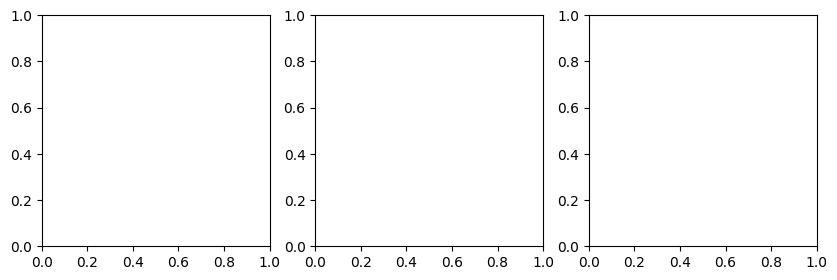

In [38]:
import matplotlib.pyplot as plt

mask_target = (test.target.mask > 0).squeeze() 
mask_source= (test.source.mask > 0).squeeze() 
mask_sample = (sample.mask > 0).squeeze()

fig, ax = plt.subplots(1, 3, figsize=(10,3))

test.target.histplot('pt_rel', mask=mask_target,  binrange=(-.1, 1), binwidth=0.01, xlabel=r'particle $p_t^{\rm rel}$',ax=ax[0], **args_tar)
sample.histplot('pt_rel', mask=mask_sample, binrange=(-.1, 1), binwidth=0.01, xlabel=r'particle $p_t^{\rm rel}$', ax=ax[0], **args_sam)
test.source.histplot('pt_rel', mask=mask_source,  binrange=(-.1, 1), binwidth=0.01, xlabel=r'particle $p_t^{\rm rel}$',ax=ax[0], **args_src)

test.target.histplot('eta_rel', mask=mask_target,  binrange=(-2.5, 2.5), binwidth=0.05, xlabel=r'particle $\Delta \eta$', ax=ax[1],  **args_tar)
sample.histplot('eta_rel', mask=mask_sample, binrange=(-2.5, 2.5), binwidth=0.05, xlabel=r'particle $\Delta \eta$', ax=ax[1], **args_sam)
test.source.histplot('eta_rel', mask=mask_source, binrange=(-2.5, 2.5), binwidth=0.05, xlabel=r'particle $\Delta \eta$', ax=ax[1],  **args_src)

test.target.histplot('phi_rel', mask=mask_target,  binrange=(-2.5, 2.5), binwidth=0.05, xlabel=r'particle $\Delta \phi$', ax=ax[2],  **args_tar)
sample.histplot('phi_rel', mask=mask_sample, binrange=(-2.5, 2.5), binwidth=0.05, xlabel=r'particle $\Delta \phi$', ax=ax[2], **args_sam)
test.source.histplot('phi_rel', mask=mask_source, binrange=(-2.5, 2.5), binwidth=0.05, xlabel=r'particle $\Delta \phi$', ax=ax[2],  **args_src)

ax[0].legend(loc='upper right', fontsize=8)
plt.tight_layout()
plt.savefig(epic_cfm.workdir / 'particle_distributions.png')
plt.show()

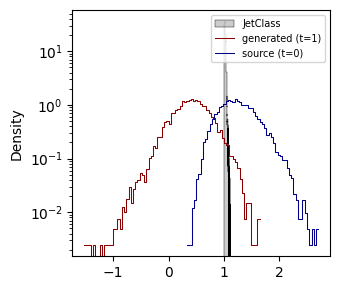

In [8]:
sample_jet_pt = sample.continuous[...,0].sum(dim=1)
target_jet_pt = test.target.continuous[...,0].sum(dim=1)
source_jet_pt = test.source.continuous[...,0].sum(dim=1)

fig, ax = plt.subplots(1, 1, figsize=(3.5,3))
sns.histplot(target_jet_pt, element='step', **args_tar)
sns.histplot(sample_jet_pt,  element='step', **args_sam)
sns.histplot(source_jet_pt, element='step', **args_src)
ax.legend(loc='upper right', fontsize=7)

plt.tight_layout()
plt.savefig(epic_cfm.workdir / 'jet_pt.png')
plt.show()

varying number of constituents (max. 128)

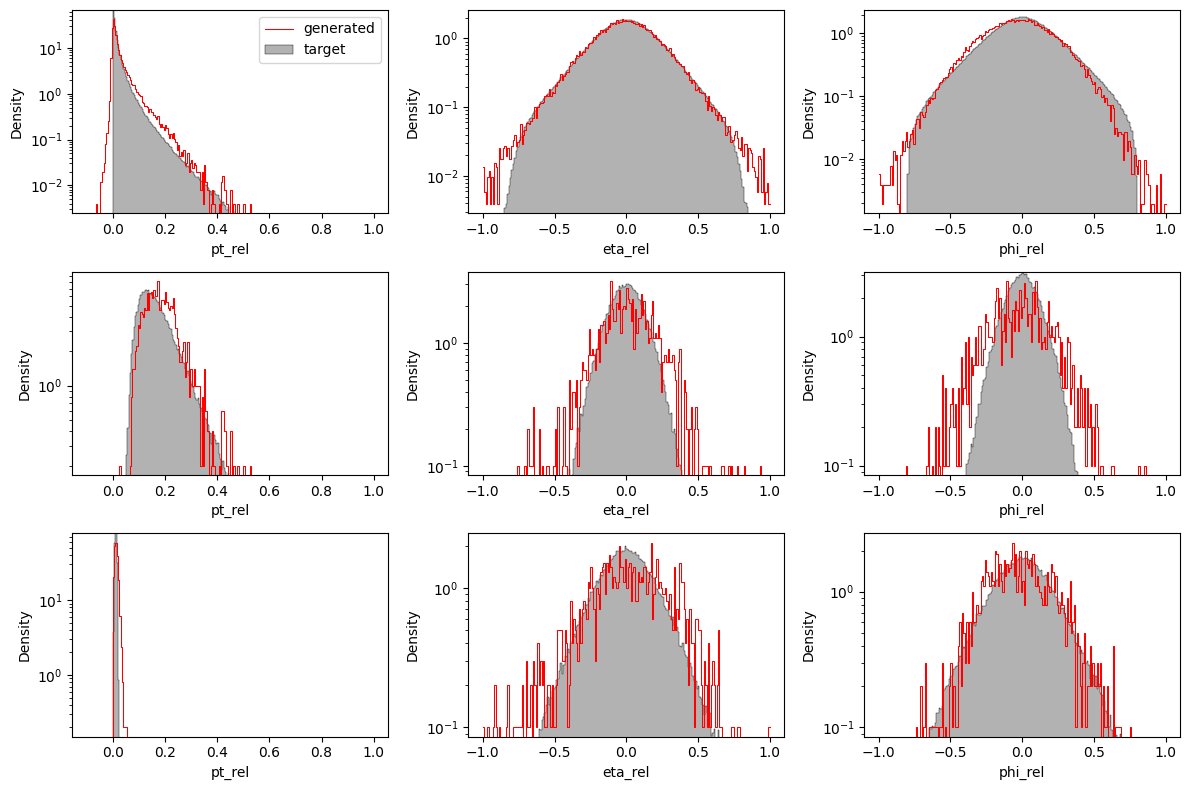

In [6]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 3, figsize=(12,8))

binrange_0, binwidth_0 = (-0.1, 1), 0.005
binrange_1, binwidth_1 = (-1, 1), 0.01
binrange_2, binwidth_2 = (-1, 1), 0.01

jets_generated.histplot('pt_rel', binrange=binrange_0, binwidth=binwidth_0, ax=ax[0,0], color='r', log_scale=(False, True), fill=False, stat='density',lw=0.75, label='generated')
jets.target.histplot('pt_rel', binrange=binrange_0, binwidth=binwidth_0, ax=ax[0,0], log_scale=(False, True),  color='k', stat='density', alpha=0.3, lw=0.3, label='target')
jets_generated.histplot('eta_rel', binrange=binrange_1, binwidth=binwidth_1, ax=ax[0,1], log_scale=(False, True), color='r', fill=False, stat='density', lw=0.75, label='generated')
jets.target.histplot('eta_rel', binrange=binrange_1, binwidth=binwidth_1, ax=ax[0,1],   log_scale=(False, True), color='k', stat='density', alpha=0.3, lw=0.3, label='target')
jets_generated.histplot('phi_rel', binrange=binrange_2, binwidth=binwidth_2, ax=ax[0,2], log_scale=(False, True), color='r', fill=False, stat='density',  lw=0.75, label='generated')
jets.target.histplot('phi_rel',binrange=binrange_2, binwidth=binwidth_2, ax=ax[0,2],  log_scale=(False, True), color='k', stat='density', alpha=0.3, lw=0.3, label='target')

jets_generated.histplot('pt_rel', idx=0, binrange=binrange_0, binwidth=binwidth_0, ax=ax[1,0], color='r', log_scale=(False, True), fill=False, stat='density',lw=0.75, label='generated')
jets.target.histplot('pt_rel', idx=0, binrange=binrange_0, binwidth=binwidth_0, ax=ax[1,0], log_scale=(False, True),  color='k', stat='density', alpha=0.3, lw=0.3, label='target')
jets_generated.histplot('eta_rel', idx=0, binrange=binrange_1, binwidth=binwidth_1, ax=ax[1,1], log_scale=(False, True), color='r', fill=False, stat='density', lw=0.75, label='generated')
jets.target.histplot('eta_rel', idx=0, binrange=binrange_1, binwidth=binwidth_1, ax=ax[1,1],   log_scale=(False, True), color='k', stat='density', alpha=0.3, lw=0.3, label='target')
jets_generated.histplot('phi_rel', idx=0, binrange=binrange_2, binwidth=binwidth_2, ax=ax[1,2], log_scale=(False, True), color='r', fill=False, stat='density',  lw=0.75, label='generated')
jets.target.histplot('phi_rel', idx=0, binrange=binrange_2, binwidth=binwidth_2, ax=ax[1,2],  log_scale=(False, True), color='k', stat='density', alpha=0.3, lw=0.3, label='target')

jets_generated.histplot('pt_rel', idx=20, binrange=binrange_0, binwidth=binwidth_0, ax=ax[2,0], color='r', log_scale=(False, True), fill=False, stat='density',lw=0.75, label='generated')
jets.target.histplot('pt_rel', idx=20, binrange=binrange_0, binwidth=binwidth_0, ax=ax[2,0], log_scale=(False, True),  color='k', stat='density', alpha=0.3, lw=0.3, label='target')
jets_generated.histplot('eta_rel', idx=20, binrange=binrange_1, binwidth=binwidth_1, ax=ax[2,1], log_scale=(False, True), color='r', fill=False, stat='density', lw=0.75, label='generated')
jets.target.histplot('eta_rel', idx=20, binrange=binrange_1, binwidth=binwidth_1, ax=ax[2,1],   log_scale=(False, True), color='k', stat='density', alpha=0.3, lw=0.3, label='target')
jets_generated.histplot('phi_rel', idx=20, binrange=binrange_2, binwidth=binwidth_2, ax=ax[2,2], log_scale=(False, True), color='r', fill=False, stat='density',  lw=0.75, label='generated')
jets.target.histplot('phi_rel', idx=20, binrange=binrange_2, binwidth=binwidth_2, ax=ax[2,2],  log_scale=(False, True), color='k', stat='density', alpha=0.3, lw=0.3, label='target')

ax[0,0].legend()
plt.tight_layout()
plt.savefig(model.workdir / 'particle_distributions.png')
plt.show()
